# Marketing Spend Optimization
***
- BC Ltd is a supplier of project management software for IT companies.
- The marketing team at ABC leverages ad campaigns, social media, client referrals and trade shows to reach decision makers at target accounts.
- The goal of the marketing campaign is to drive free trial registration generated by showcasing the platform features and associated benefits (time and cost).

In [4]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import warnings
from scipy.stats import f_oneway
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import re
import openpyxl
import matplotlib.font_manager as fm
from matplotlib.ticker import FuncFormatter
pd.options.display.float_format = "{:.2f}".format
from wordcloud import WordCloud

In [5]:
# Set the font path to the location of your Century Gothic font
font_path = "GOTHIC.TTF"

# Create a font dictionary with Century Gothic font family
font_prop = fm.FontProperties(fname = font_path)

# Set the default font family to Century Gothic
plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams.update({'font.size': 11})

In [11]:
df = pd.read_excel(r'../Source Data/analytics-case-study-data.xlsx')
df.head()

,Campaign ID,Campaign Name,Prospect Status,Account ID,Account Name,Country,Prospect ID,Opt-In,Opt-In Source,Opt-In Timestamp,Opt-Out Timestamp,Job Title,Prospect Source
0,FY23-Q3-global-PROD461-valentines_day_special,Valentine's Day Special,No Show,0014M0000mXuCYxQAN,Redwood Enterprises,Italy,0034M0000qUkSoNQAV,Yes,online purchase,2023-06-23 06:11:00,NaT,Senior Managed Care Social Media,Advertisement
1,FY23-Q3-global-PROD461-annual_clearance_event,Annual Clearance Event,Responded,0014M0000mXuCYxQAN,Redwood Enterprises,Italy,0034M0000HOb6cnQAD,Yes,social media campaign,NaT,2023-11-26 06:11:00,SENIOR ANALYST,Trade Show
2,FY23-Q3-global-PROD461-spring_flower_sale,Spring Flower Sale,No Show,0014M0000mXuCYxQAN,Redwood Enterprises,Italy,0034M0000rRLR2bQAX,Yes,referral program,NaT,2023-07-21 06:11:00,Data- Bij DE Gemeente Leeuwarden Analyst,Referral
3,FY23-Q3-global-PROD461-spring_break_sale,Spring Break Sale,No Show,0014M0000mXuCYxQAN,Redwood Enterprises,Italy,0034M0000hRZsn9QAD,Yes,event registration,NaT,2023-07-11 06:11:00,Data Analyst,Trade Show
4,FY23-Q3-global-PROD461-spring_flower_sale,Spring Flower Sale,No Show,0014M0000mXuCYxQAN,Redwood Enterprises,Italy,0034M0000pVvfBmQAJ,Yes,event registration,NaT,2023-11-26 06:11:00,Data Scientist / Analyst / Engineer,Advertisement


In [12]:
df['Opt-In'].value_counts()

Opt-In
Yes    956
No      30
Name: count, dtype: int64

### Dataset Overview
---

This dataset encompasses a range of attributes related to marketing campaigns and the interactions with potential clients:

1. **Campaign ID**: A unique identifier for each campaign, generated by combining the campaign's date, time, and other key attributes.
2. **Campaign Name**: The title or name assigned to the marketing campaign.
3. **Prospect Status**: The stage at which a prospect is within the campaign. Possible statuses include:
    - **Responded**: The prospect has shown initial interest by responding.
    - **No Show**: The prospect did not attend the scheduled demo.
    - **Attended**: The prospect attended the demo session.
    - **Registered**: The prospect registered for a free trial after attending the demo.
4. **Account ID**: A unique identifier for each account, as recorded in Salesforce, to track their journey through the marketing funnel.
5. **Account Name**: The name of the company that is the client.
6. **Country**: The country in which the client account is based.
7. **Prospect ID**: A unique identifier for the individual prospect or contact within the client account.
8. **Opt-In**: Indicates whether the prospect has agreed to receive newsletters (Yes/No).
9. **Opt-In Source**: The channel through which the prospect first learned about the product or chose to opt into the newsletter program.
10. **Opt-In Timestamp**: The date and time when the prospect opted into receiving newsletters.
11. **Opt-Out Timestamp**: The date and time when the prospect opted out of receiving newsletters.
12. **Job Title**: The job title and role of the prospect within their company, categorized to assess their influence:
    - **Practitioner**: Typically below managerial level, such as analysts who use the software regularly.
    - **Decision Maker**: Mid to upper management, responsible for evaluating and deciding on software purchases.
    - **Executive**: High-level executives interested in software deployment across the organization.
13. **Prospect Source**: The origin through which the prospect became aware of the product, such as via Advertisement, Social Media, Referral, or Trade Show.

In [13]:
df.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Campaign ID        1000 non-null   object        
 1   Campaign Name      1000 non-null   object        
 2   Prospect Status    1000 non-null   object        
 3   Account ID         1000 non-null   object        
 4   Account Name       1000 non-null   object        
 5   Country            1000 non-null   object        
 6   Prospect ID        1000 non-null   object        
 7   Opt-In             986 non-null    object        
 8   Opt-In Source      875 non-null    object        
 9   Opt-In Timestamp   954 non-null    datetime64[ns]
 10  Opt-Out Timestamp  32 non-null     datetime64[ns]
 11  Job Title          1000 non-null   object        
 12  Prospect Source    1000 non-null   object        
dtypes: datetime64[ns](2), object(11)
memory usage: 101.7+ KB


## Case Study Steps

### Cleaning/ Preparing the data
 - Document your steps to normalize the data.
    - Were there missing values? How did you complete the data?
    - Did you convert any data types?
    - What are the derived values you used?


## Important:
- In order to avoid making assumptions that could potentially alter the outcomes of any analyses relying on this data, a column called `For Review` will be created, innitially as `False` where any potential annomally will be flag.

In [14]:
df['For Review'] = False

In [15]:
df['Opt-In Timestamp'].dt.year.value_counts()

Opt-In Timestamp
2023.00    947
2025.00      7
Name: count, dtype: int64

In [16]:
df['Opt-Out Timestamp'].dt.year.value_counts()

Opt-Out Timestamp
2023.00    24
2025.00     8
Name: count, dtype: int64

### Comments:
---
- 15 entries have record a year of 2025.
    - **Decision**: This is considered an anomally in the data and will be flagged as 'For Review' in order to keep the data as logical as possible.

In [17]:
df.loc[(df['Opt-In Timestamp'].dt.year == 2025) | (df['Opt-Out Timestamp'].dt.year == 2025), ['For Review', 'Comment']] = True, 'Year is 2025'
df

,Campaign ID,Campaign Name,Prospect Status,Account ID,Account Name,Country,Prospect ID,Opt-In,Opt-In Source,Opt-In Timestamp,Opt-Out Timestamp,Job Title,Prospect Source,For Review,Comment
0,FY23-Q3-global-PROD461-valentines_day_special,Valentine's Day Special,No Show,0014M0000mXuCYxQAN,Redwood Enterprises,Italy,0034M0000qUkSoNQAV,Yes,online purchase,2023-06-23 06:11:00,NaT,Senior Managed Care Social Media,Advertisement,False,NaN
1,FY23-Q3-global-PROD461-annual_clearance_event,Annual Clearance Event,Responded,0014M0000mXuCYxQAN,Redwood Enterprises,Italy,0034M0000HOb6cnQAD,Yes,social media campaign,NaT,2023-11-26 06:11:00,SENIOR ANALYST,Trade Show,False,NaN
2,FY23-Q3-global-PROD461-spring_flower_sale,Spring Flower Sale,No Show,0014M0000mXuCYxQAN,Redwood Enterprises,Italy,0034M0000rRLR2bQAX,Yes,referral program,NaT,2023-07-21 06:11:00,Data- Bij DE Gemeente Leeuwarden Analyst,Referral,False,NaN
3,FY23-Q3-global-PROD461-spring_break_sale,Spring Break Sale,No Show,0014M0000mXuCYxQAN,Redwood Enterprises,Italy,0034M0000hRZsn9QAD,Yes,event registration,NaT,2023-07-11 06:11:00,Data Analyst,Trade Show,False,NaN
4,FY23-Q3-global-PROD461-spring_flower_sale,Spring Flower Sale,No Show,0014M0000mXuCYxQAN,Redwood Enterprises,Italy,0034M0000pVvfBmQAJ,Yes,event registration,NaT,2023-11-26 06:11:00,Data Scientist / Analyst / Engineer,Advertisement,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,FY23-Q3-global-PROD461-cyber_monday_sale,Cyber Monday Sale,Attended,0014M0000Ri9Qe6QAF,Windcrest Innovations,China,0034M0000pp1pUeQAI,Yes,NaN,2023-05-02 06:11:00,NaT,Senior Analyst,Advertisement,False,NaN
996,FY23-Q3-global-PROD461-cyber_monday_blowout,Cyber Monday Blowout,No Show,0014M0000Ri9Qe6QAF,Windcrest Innovations,China,0034M0000qcA3rMQAV,Yes,NaN,2023-02-11 06:11:00,NaT,IT Business Analyst,Advertisement,False,NaN
997,FY23-Q3-global-PROD461-fall_into_savings,Fall Into Savings,No Show,0014M0000Ri9Qe6QAF,Windcrest Innovations,China,0034M0000qVJd4KQAZ,Yes,referral program,2023-06-15 06:11:00,NaT,Systems Operations Analyst II (Americas),Advertisement,False,NaN
998,FY23-Q3-global-PROD461-cyber_monday_blowout,Cyber Monday Blowout,No Show,0014M0000Ri9Qe6QAF,Windcrest Innovations,China,0034M0000o1vNNiQAM,Yes,social media campaign,2023-08-10 06:11:00,NaT,Tools & Technology Lead Senior Data Analyst,Advertisement,False,NaN


### Comments
---
- 3 `Opt-In Timestamp` with values and NaN in `Opt-In`.
    - **Decision**: `Opt-In` = Yes

In [18]:
df[(df['Opt-In'].isna()) & ~(df['Opt-In Timestamp'].isna()) & (df['For Review'] != True)]

,Campaign ID,Campaign Name,Prospect Status,Account ID,Account Name,Country,Prospect ID,Opt-In,Opt-In Source,Opt-In Timestamp,Opt-Out Timestamp,Job Title,Prospect Source,For Review,Comment
20,FY23-Q3-global-PROD461-summer_clearance_sale,Summer Clearance Sale,No Show,0014M0000DkP01UQAZ,Coral Systems,United States,0034M0000klMsmiQAC,NaN,event registration,2023-08-06 06:11:00,NaT,Senior Research Analyst,Advertisement,False,NaN
21,FY23-Q3-global-PROD461-fall_favorites_sale,Fall Favorites Sale,No Show,0014M0000DkP01UQAZ,Coral Systems,United States,0034M0000pVRVwFQAX,NaN,email subscription,2023-07-01 06:11:00,NaT,"Senior Business, Payroll Systems Analyst",Trade Show,False,NaN
22,FY23-Q3-global-PROD461-spring_sales_bonanza,Spring Sales Bonanza,Responded,0014M0000DkP01UQAZ,Coral Systems,United States,0034M0000FbwBd0QAF,NaN,NaN,2023-03-07 06:11:00,NaT,Information Security Analyst,Advertisement,False,NaN


In [19]:
df.loc[(df['Opt-In'].isna()) & ~(df['Opt-In Timestamp'].isna()) & (df['For Review'] != True), 'Opt-In'] = 'Yes'

### Comments
---
- 2 `Opt-In` as No but there is a value in the `Opt-In Timestamp`.
    - **Decision**: This could indicate a discrepancy in data recording or a mistake during data entry and will be flagged as 'For Review' in order to keep the data as logical as possible.

In [20]:
df[(df['Opt-In'] == 'No') & ~(df['Opt-In Timestamp'].isna()) & (df['For Review'] != True)]

,Campaign ID,Campaign Name,Prospect Status,Account ID,Account Name,Country,Prospect ID,Opt-In,Opt-In Source,Opt-In Timestamp,Opt-Out Timestamp,Job Title,Prospect Source,For Review,Comment
10,FY23-Q3-global-PROD461-valentines_day_special,Valentine's Day Special,No Show,0014M0000mXuCYxQAN,Redwood Enterprises,Italy,0034M0000q4U8WsQAI,No,online contest entry,2023-06-25 06:11:00,NaT,IT Project Analyst,Advertisement,False,NaN
11,FY23-Q3-global-PROD461-cyber_monday_special,Cyber Monday Special,No Show,0014M0000mXuCYxQAN,Redwood Enterprises,Italy,0034M0000NtXhrRQAV,No,event registration,2023-07-29 06:11:00,NaT,"""Information, Infrastructure Operations Techno...",Trade Show,False,NaN


In [21]:
df.loc[(df['Opt-In'] == 'No') & ~(df['Opt-In Timestamp'].isna()) & (df['For Review'] != True), ['For Review', 'Comment']] = True, 'Opt-In as No but Opt-In Timestamp was recorded'

### Comments
---
- 4 `Opt-In` as No but no date for the `Opt-Out Timestamp`.
    - **Decision**: This could indicate a discrepancy in data recording or a mistake during data entry and will be flagged as 'For Review' in order to keep the data as logical as possible.

In [22]:
df[(df['Opt-In'] == 'No') & (df['Opt-Out Timestamp'].isna()) & (df['For Review'] != True)]

,Campaign ID,Campaign Name,Prospect Status,Account ID,Account Name,Country,Prospect ID,Opt-In,Opt-In Source,Opt-In Timestamp,Opt-Out Timestamp,Job Title,Prospect Source,For Review,Comment
84,FY23-Q3-global-PROD461-summer_festival_sale,Summer Festival Sale,No Show,0014M0000Kuiz6SQAR,Ironclad Solutions,United Kingdom,0034M0000qWZD9jQAJ,No,email subscription,NaT,NaT,"Analytics, Japac, SMB & Scaled Head of Busines...",Advertisement,False,NaN
85,FY23-Q3-global-PROD461-summer_clearance_sale,Summer Clearance Sale,No Show,0014M0000Kuiz6SQAR,Ironclad Solutions,United Kingdom,0034M0000oXID9vQAH,No,online contest entry,NaT,NaT,Data Analyst,Trade Show,False,NaN
86,FY23-Q3-global-PROD461-summer_sizzle_sale,Summer Sizzle Sale,Responded,0014M0000Kuiz6SQAR,Ironclad Solutions,United Kingdom,0034M0000qcA52KQAZ,No,online purchase,NaT,NaT,Senior Analyst & Software Engineer,Advertisement,False,NaN
87,FY23-Q3-global-PROD461-annual_summer_blowout,Annual Summer Blowout,Attended,0014M0000Kuiz6SQAR,Ironclad Solutions,United Kingdom,0034M0000oF42c5QAJ,No,email subscription,NaT,NaT,Senior Analyst & Software Engineer,Advertisement,False,NaN


In [23]:
df.loc[(df['Opt-In'] == 'No') & (df['Opt-Out Timestamp'].isna()) & (df['For Review'] != True), ['For Review', 'Comment']] = True, 'Opt-In as No but No Opt-Out Timestamp was recorded'

### Comments
---
- 10 `Opt-In` as Yes but no date for the `Opt-In Timestamp`.
    - **Decision**: This could indicate a discrepancy in data recording or a mistake during data entry and will be flagged as 'For Review' in order to keep the data as logical as possible.

In [24]:
df[(df['Opt-In'] == 'Yes') & (df['Opt-In Timestamp'].isna()) & (df['For Review'] != True)]

,Campaign ID,Campaign Name,Prospect Status,Account ID,Account Name,Country,Prospect ID,Opt-In,Opt-In Source,Opt-In Timestamp,Opt-Out Timestamp,Job Title,Prospect Source,For Review,Comment
1,FY23-Q3-global-PROD461-annual_clearance_event,Annual Clearance Event,Responded,0014M0000mXuCYxQAN,Redwood Enterprises,Italy,0034M0000HOb6cnQAD,Yes,social media campaign,NaT,2023-11-26 06:11:00,SENIOR ANALYST,Trade Show,False,NaN
2,FY23-Q3-global-PROD461-spring_flower_sale,Spring Flower Sale,No Show,0014M0000mXuCYxQAN,Redwood Enterprises,Italy,0034M0000rRLR2bQAX,Yes,referral program,NaT,2023-07-21 06:11:00,Data- Bij DE Gemeente Leeuwarden Analyst,Referral,False,NaN
3,FY23-Q3-global-PROD461-spring_break_sale,Spring Break Sale,No Show,0014M0000mXuCYxQAN,Redwood Enterprises,Italy,0034M0000hRZsn9QAD,Yes,event registration,NaT,2023-07-11 06:11:00,Data Analyst,Trade Show,False,NaN
4,FY23-Q3-global-PROD461-spring_flower_sale,Spring Flower Sale,No Show,0014M0000mXuCYxQAN,Redwood Enterprises,Italy,0034M0000pVvfBmQAJ,Yes,event registration,NaT,2023-11-26 06:11:00,Data Scientist / Analyst / Engineer,Advertisement,False,NaN
5,FY23-Q3-global-PROD461-annual_clearance_event,Annual Clearance Event,Responded,0014M0000mXuCYxQAN,Redwood Enterprises,Italy,0034M0000ltjTiyQAE,Yes,newsletter subscription,NaT,2023-06-21 06:11:00,Vice President Analyst,Advertisement,False,NaN
6,FY23-Q3-global-PROD461-fall_favorites_sale,Fall Favorites Sale,No Show,0014M0000mXuCYxQAN,Redwood Enterprises,Italy,0034M0000tRCdPtQAL,Yes,online contest entry,NaT,NaT,IT analyst,Advertisement,False,NaN
7,FY23-Q3-global-PROD461-fall_favorites_discounts,Fall Favorites Discounts,Responded,0014M0000mXuCYxQAN,Redwood Enterprises,Italy,0034M0000ENlXNbQAX,Yes,NaN,NaT,NaT,Data Analyst,Advertisement,False,NaN
8,FY23-Q3-global-PROD461-annual_summer_clearance,Annual Summer Clearance,No Show,0014M0000mXuCYxQAN,Redwood Enterprises,Italy,0034M0000k8nRgGQAZ,Yes,email subscription,NaT,NaT,Business Analyst,Advertisement,False,NaN
9,FY23-Q3-global-PROD461-spring_sales_bonanza,Spring Sales Bonanza,Responded,0014M0000mXuCYxQAN,Redwood Enterprises,Italy,0034M0000QmeZcEQAX,Yes,online contest entry,NaT,NaT,Information Technology Analyst (GRC),Advertisement,False,NaN


In [25]:
df.loc[(df['Opt-In'] == 'Yes') & (df['Opt-In Timestamp'].isna()) & (df['For Review'] != True), ['For Review', 'Comment']] = True, 'Opt-In as Yes but No Opt-In Timestamp was recorded'

### Comments
---
- Missing Opt-In values not revised yet:
    - 6 `Opt-In` as missing but no date for the `Opt-In Timestamp` or `Opt-Out Timestamp`.
        - **Decision**: This could indicate a discrepancy in data recording or a mistake during data entry and will be flagged as 'For Review' in order to keep the data as logical as possible.

In [26]:
df[(df['Opt-In'].isna()) & (df['For Review'] != True)]

,Campaign ID,Campaign Name,Prospect Status,Account ID,Account Name,Country,Prospect ID,Opt-In,Opt-In Source,Opt-In Timestamp,Opt-Out Timestamp,Job Title,Prospect Source,For Review,Comment
200,FY23-Q3-global-PROD461-labor_day_special,Labor Day Special,Registered,0014M0000C3Gz3EQAT,Crimson Peak Technologies,Canada,0034M0000nMWzJsQAJ,NaN,referral program,NaT,NaT,Product Analyst,Advertisement,False,NaN
257,FY23-Q3-global-PROD461-halloween_bash,Halloween Bash,No Show,0014M0000HCVQJZQA18,Pinecrest Solutions,Spain,0034M0000o7mdG7QAI,NaN,referral program,NaT,NaT,Data Analytics Sr,Trade Show,False,NaN
391,FY23-Q3-global-PROD461-springtime_savings,Springtime Savings,No Show,0014M0000kYyeJhQAJ,Harborview Technologies,United States,0034M0000tCbeHuQAJ,NaN,online contest entry,NaT,NaT,Sustainability Analyst,Advertisement,False,NaN
447,FY23-Q3-global-PROD461-spring_flower_sale,Spring Flower Sale,Responded,0014M0000GNNRu6QAH,Blackwood Systems,China,0034M0000nplfMRQAY,NaN,online contest entry,NaT,NaT,Systems Analyst,Advertisement,False,NaN
864,FY23-Q3-global-PROD461-winter_wonderland_sale,Winter Wonderland Sale,No Show,0014M0000RdTXmeQAH,Windstone Enterprises,France,0034M0000PqWimEQAT,NaN,email subscription,NaT,NaT,Director Finance and Analytics,Referral,False,NaN
903,FY23-Q3-global-PROD461-halloween_haunt,Halloween Haunt,No Show,0014M0000HV1I3QQAT,Stonewall Systems,Mexico,0034M0000qE4tjPQAX,NaN,online contest entry,NaT,NaT,Technical Analyst,Trade Show,False,NaN


In [27]:
df.loc[(df['Opt-In'].isna()) & (df['For Review'] != True), ['For Review', 'Comment']] = True, 'Opt-In is missing and no record for Opt-In Timestamp or Opt-Out Timestamp'

In [28]:
df[(df['Opt-In'] == 'Yes') & ~(df['Opt-Out Timestamp'].isna()) & (df['For Review'] == False)]

,Campaign ID,Campaign Name,Prospect Status,Account ID,Account Name,Country,Prospect ID,Opt-In,Opt-In Source,Opt-In Timestamp,Opt-Out Timestamp,Job Title,Prospect Source,For Review,Comment


### Comments
---
- 125 missing `Opt-In Source`:
    - **Decision**: As no source is identified and this represents 12.5% of the data, a new category will be created as 'Unknown' 

In [29]:
df[df['Opt-In Source'].isna()]

,Campaign ID,Campaign Name,Prospect Status,Account ID,Account Name,Country,Prospect ID,Opt-In,Opt-In Source,Opt-In Timestamp,Opt-Out Timestamp,Job Title,Prospect Source,For Review,Comment
7,FY23-Q3-global-PROD461-fall_favorites_discounts,Fall Favorites Discounts,Responded,0014M0000mXuCYxQAN,Redwood Enterprises,Italy,0034M0000ENlXNbQAX,Yes,NaN,NaT,NaT,Data Analyst,Advertisement,True,Opt-In as Yes but No Opt-In Timestamp was reco...
12,FY23-Q3-global-PROD461-spring_flower_sale,Spring Flower Sale,No Show,0014M0000mXuCYxQAN,Redwood Enterprises,Italy,0034M0000kCix2eQAB,Yes,NaN,2023-10-05 06:11:00,NaT,Data Analyst,Advertisement,False,NaN
22,FY23-Q3-global-PROD461-spring_sales_bonanza,Spring Sales Bonanza,Responded,0014M0000DkP01UQAZ,Coral Systems,United States,0034M0000FbwBd0QAF,Yes,NaN,2023-03-07 06:11:00,NaT,Information Security Analyst,Advertisement,False,NaN
26,FY23-Q3-global-PROD461-annual_clearance_event,Annual Clearance Event,Responded,0014M0000DkP01UQAZ,Coral Systems,United States,0034M0000tlzpWQQAZ,Yes,NaN,2023-03-23 06:11:00,NaT,Senior Privacy Security Analyst,Advertisement,False,NaN
30,FY23-Q3-global-PROD461-summer_sizzle_sale,Summer Sizzle Sale,No Show,0014M0000DkP01UQAZ,Coral Systems,United States,0034M0000NlEjZsQAL,Yes,NaN,2023-01-28 06:11:00,NaT,Data Analyst,Advertisement,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981,FY23-Q3-global-PROD461-fall_into_savings,Fall Into Savings,No Show,0014M0000Ri9Qe6QAF,Windcrest Innovations,China,0034M0000q5vnvaQAJ,Yes,NaN,2023-03-01 06:11:00,NaT,Chief Analytics Officer,Advertisement,False,NaN
985,FY23-Q3-global-PROD461-spring_clearance_event,Spring Clearance Event,No Show,0014M0000Ri9Qe6QAF,Windcrest Innovations,China,0034M0000qhV7LXQAZ,Yes,NaN,2023-02-09 06:11:00,NaT,IT- Security Analyst & Associate,Advertisement,False,NaN
995,FY23-Q3-global-PROD461-cyber_monday_sale,Cyber Monday Sale,Attended,0014M0000Ri9Qe6QAF,Windcrest Innovations,China,0034M0000pp1pUeQAI,Yes,NaN,2023-05-02 06:11:00,NaT,Senior Analyst,Advertisement,False,NaN
996,FY23-Q3-global-PROD461-cyber_monday_blowout,Cyber Monday Blowout,No Show,0014M0000Ri9Qe6QAF,Windcrest Innovations,China,0034M0000qcA3rMQAV,Yes,NaN,2023-02-11 06:11:00,NaT,IT Business Analyst,Advertisement,False,NaN


In [30]:
df.loc[df['Opt-In Source'].isna(), 'Opt-In Source'] = 'Unknown'

### Comments
---
- All columns seems to be in the right format, however it is preferable to have the `Opt-In` column as boolen:
    - **Decision**: `Opt-In` column will be transformed as `{'Yes': True, 'No': False}`

In [31]:
df['Opt-In'].replace({'Yes': True, 'No': False}, inplace = True)
df['Opt-In'] = df['Opt-In'].astype(bool)
df

,Campaign ID,Campaign Name,Prospect Status,Account ID,Account Name,Country,Prospect ID,Opt-In,Opt-In Source,Opt-In Timestamp,Opt-Out Timestamp,Job Title,Prospect Source,For Review,Comment
0,FY23-Q3-global-PROD461-valentines_day_special,Valentine's Day Special,No Show,0014M0000mXuCYxQAN,Redwood Enterprises,Italy,0034M0000qUkSoNQAV,True,online purchase,2023-06-23 06:11:00,NaT,Senior Managed Care Social Media,Advertisement,False,NaN
1,FY23-Q3-global-PROD461-annual_clearance_event,Annual Clearance Event,Responded,0014M0000mXuCYxQAN,Redwood Enterprises,Italy,0034M0000HOb6cnQAD,True,social media campaign,NaT,2023-11-26 06:11:00,SENIOR ANALYST,Trade Show,True,Opt-In as Yes but No Opt-In Timestamp was reco...
2,FY23-Q3-global-PROD461-spring_flower_sale,Spring Flower Sale,No Show,0014M0000mXuCYxQAN,Redwood Enterprises,Italy,0034M0000rRLR2bQAX,True,referral program,NaT,2023-07-21 06:11:00,Data- Bij DE Gemeente Leeuwarden Analyst,Referral,True,Opt-In as Yes but No Opt-In Timestamp was reco...
3,FY23-Q3-global-PROD461-spring_break_sale,Spring Break Sale,No Show,0014M0000mXuCYxQAN,Redwood Enterprises,Italy,0034M0000hRZsn9QAD,True,event registration,NaT,2023-07-11 06:11:00,Data Analyst,Trade Show,True,Opt-In as Yes but No Opt-In Timestamp was reco...
4,FY23-Q3-global-PROD461-spring_flower_sale,Spring Flower Sale,No Show,0014M0000mXuCYxQAN,Redwood Enterprises,Italy,0034M0000pVvfBmQAJ,True,event registration,NaT,2023-11-26 06:11:00,Data Scientist / Analyst / Engineer,Advertisement,True,Opt-In as Yes but No Opt-In Timestamp was reco...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,FY23-Q3-global-PROD461-cyber_monday_sale,Cyber Monday Sale,Attended,0014M0000Ri9Qe6QAF,Windcrest Innovations,China,0034M0000pp1pUeQAI,True,Unknown,2023-05-02 06:11:00,NaT,Senior Analyst,Advertisement,False,NaN
996,FY23-Q3-global-PROD461-cyber_monday_blowout,Cyber Monday Blowout,No Show,0014M0000Ri9Qe6QAF,Windcrest Innovations,China,0034M0000qcA3rMQAV,True,Unknown,2023-02-11 06:11:00,NaT,IT Business Analyst,Advertisement,False,NaN
997,FY23-Q3-global-PROD461-fall_into_savings,Fall Into Savings,No Show,0014M0000Ri9Qe6QAF,Windcrest Innovations,China,0034M0000qVJd4KQAZ,True,referral program,2023-06-15 06:11:00,NaT,Systems Operations Analyst II (Americas),Advertisement,False,NaN
998,FY23-Q3-global-PROD461-cyber_monday_blowout,Cyber Monday Blowout,No Show,0014M0000Ri9Qe6QAF,Windcrest Innovations,China,0034M0000o1vNNiQAM,True,social media campaign,2023-08-10 06:11:00,NaT,Tools & Technology Lead Senior Data Analyst,Advertisement,False,NaN


### Comments
---
- A job title category column will be created in order to label the prospect category into:
    + **Practitioner:** is someone who is typically below a manager level like an analyst and would be the person consuming the software on a daily basis.
    + **Decision maker:** is a manager- director level prospect that manages multiple teams and is the decision maker on the value to his teams.
    + **Executive:** an executive interested in using this for the entire organization.
- Some values in `Job Title` have '' or "", this will be removed first.

In [32]:
df['Job Title'].replace({'"': '', "'": '', r'\s+': ' '}, regex = True, inplace = True)
df['Job Title'] = df['Job Title'].str.replace('.', '').str.title()
df['Job Title'] = df['Job Title'].apply(lambda x: re.sub(r'\s?&\s?', ' & ', x))

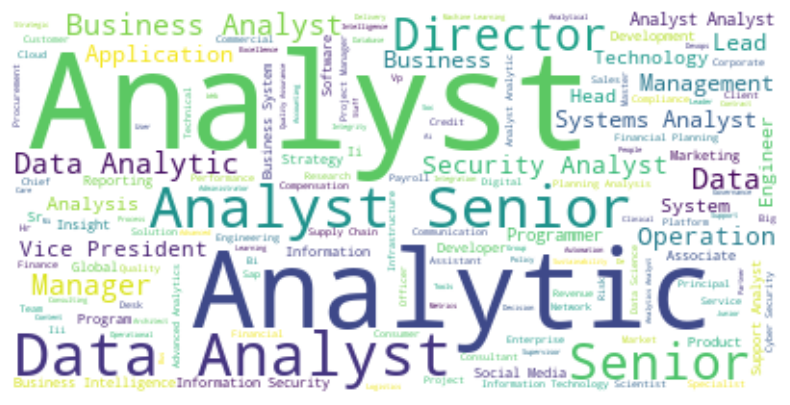

In [33]:
job_titles_string = ' '.join(df['Job Title'].dropna())

wordcloud = WordCloud(width = 400, height = 200, background_color = 'white').generate(job_titles_string)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

In [34]:
categories = dict(Practitioner = ["Analyst", "Engineer", "Developer", "Specialist", "Coordinator", "Technician", "Associate", "Social Media", "Consultant", "Analysis", "Analytics", "Designer"], 
            Desicion_Maker = ["Manager", "Director", "Direcror", "Lead", "Head", "Managed", "Management", "Sr", "Senior", "Direktør"],
            Executive = ["CEO", "CFO", "COO", "CTO", "President", "Vice President", "Executive", "Officer", "VP"])

In [35]:
for categorie, keywords in categories.items():
    df.loc[df['Job Title'].str.lower().str.contains('|'.join(keywords).lower()), 'Prospect Category by keyword'] = categorie
df.head()

,Campaign ID,Campaign Name,Prospect Status,Account ID,Account Name,Country,Prospect ID,Opt-In,Opt-In Source,Opt-In Timestamp,Opt-Out Timestamp,Job Title,Prospect Source,For Review,Comment,Prospect Category by keyword
0,FY23-Q3-global-PROD461-valentines_day_special,Valentine's Day Special,No Show,0014M0000mXuCYxQAN,Redwood Enterprises,Italy,0034M0000qUkSoNQAV,True,online purchase,2023-06-23 06:11:00,NaT,Senior Managed Care Social Media,Advertisement,False,NaN,Desicion_Maker
1,FY23-Q3-global-PROD461-annual_clearance_event,Annual Clearance Event,Responded,0014M0000mXuCYxQAN,Redwood Enterprises,Italy,0034M0000HOb6cnQAD,True,social media campaign,NaT,2023-11-26 06:11:00,Senior Analyst,Trade Show,True,Opt-In as Yes but No Opt-In Timestamp was reco...,Desicion_Maker
2,FY23-Q3-global-PROD461-spring_flower_sale,Spring Flower Sale,No Show,0014M0000mXuCYxQAN,Redwood Enterprises,Italy,0034M0000rRLR2bQAX,True,referral program,NaT,2023-07-21 06:11:00,Data- Bij De Gemeente Leeuwarden Analyst,Referral,True,Opt-In as Yes but No Opt-In Timestamp was reco...,Practitioner
3,FY23-Q3-global-PROD461-spring_break_sale,Spring Break Sale,No Show,0014M0000mXuCYxQAN,Redwood Enterprises,Italy,0034M0000hRZsn9QAD,True,event registration,NaT,2023-07-11 06:11:00,Data Analyst,Trade Show,True,Opt-In as Yes but No Opt-In Timestamp was reco...,Practitioner
4,FY23-Q3-global-PROD461-spring_flower_sale,Spring Flower Sale,No Show,0014M0000mXuCYxQAN,Redwood Enterprises,Italy,0034M0000pVvfBmQAJ,True,event registration,NaT,2023-11-26 06:11:00,Data Scientist / Analyst / Engineer,Advertisement,True,Opt-In as Yes but No Opt-In Timestamp was reco...,Practitioner


# AI aproach for Job Title categorization
---
    - Since a categorization by keywords could give a good approximation, using LLM to do this task can offer better results since it is able to contextualize the job title and assign the most likely role. 

In [ ]:
from openai import OpenAI
import json

api_key = 'secret_key_from_openAI'

client = OpenAI(api_key = api_key)

def get_completion(instruction):
    response = client.chat.completions.create(
        model = "gpt-4-turbo-preview",
        messages = [{"role": "user", "content": instruction}],
        response_format =  {"type": "json_object"},
        max_tokens = 2048
    )
    
    output = response.choices[0].message.content
    
    return output

In [246]:
import math

job_titles = df['Job Title'].unique()
qty_job_titles = df['Job Title'].unique().shape[0]
k = 0
threshold = 30
new_job_titles = []
max_chunks = math.ceil(qty_job_titles / threshold)

for i in range(max_chunks):
    if k + threshold < qty_job_titles:
        job_titles_splited = job_titles[k: threshold * (i + 1)]
        k += threshold
    else:
        job_titles_splited = job_titles[k: ]
        
    new_job_titles.append(job_titles_splited)

In [500]:
categories = []
for job_title in new_job_titles:
    
    instruction = f'''Categorize te following job titles into 'Practitioner', 'Decision Maker', or 'Executive'.
                        Consider:
                            a. Practitioner = is someone who is typically below a manager level like an analyst and would be the person consuming the software on a daily basis.
                            b. Decision maker - is a manager- director level prospect that manages multiple teams and is the decision maker on the value to his teams.
                            c. Executive - an executive interested in using this for the entire organization.
                        Just give the most likely category name in json where job title are the keys and category the value: {job_title}'''
    
    category = get_completion(instruction)
    category = json.loads(category)
    #break
    category = pd.DataFrame.from_dict(category, orient = 'index').reset_index()
    category.columns = ['Job Title', 'Prospect Category by AI']
    categories.append(category)

categories = pd.concat(categories)
categories.reset_index(drop = True)
categories.drop_duplicates(subset = 'Job Title', inplace = True)
categories['Job Title'] = categories['Job Title'].str.replace('.', '')
categories

,Job Title,Prospect Category by AI
0,Senior Managed Care Social Media,Practitioner
1,Senior Analyst,Practitioner
2,Data- Bij De Gemeente Leeuwarden Analyst,Practitioner
3,Data Analyst,Practitioner
4,Data Scientist / Analyst / Engineer,Practitioner
...,...,...
13,Customer Insight Analyst,Practitioner
14,Client Experience Analyst,Practitioner
15,Systems Operations Analyst Ii (Americas),Practitioner
16,Tools & Technology Lead Senior Data Analyst,Practitioner


In [503]:
df = pd.merge(df, categories, on = 'Job Title', how = 'left')

In [508]:
countries = df['Country'].unique()
instruction = f'''Categorize te following countries into 'LATAM', 'EMEA', 'APAC' or 'NORTHAM'.
                        Just give the most likely region name in json where Country are the keys and Region is the value: {countries}'''
                        
regions = get_completion(instruction)
regions = json.loads(regions)
regions = pd.DataFrame.from_dict(regions, orient = 'index').reset_index()
regions.columns = ['Country', 'Region']

regions

,Country,Region
0,Italy,EMEA
1,United States,NORTHAM
2,Argentina,LATAM
3,Canada,NORTHAM
4,United Kingdom,EMEA
5,India,APAC
6,Mexico,LATAM
7,Spain,EMEA
8,Brazil,LATAM
9,Japan,APAC


In [510]:
df = pd.merge(df, regions, on = 'Country', how = 'left')

In [42]:
df.to_parquet(r'../Output Data/Marketing Spend Optimization.parquet', index = False)

In [92]:
df = pd.read_parquet(r'../Output Data/Marketing Spend Optimization.parquet')

In [93]:
df.head()

,Unnamed: 0,Campaign ID,Campaign Name,Prospect Status,Account ID,Account Name,Country,Prospect ID,Opt-In,Opt-In Source,Opt-In Timestamp,Opt-Out Timestamp,Job Title,Prospect Source,For Review,Comment,Prospect Category by keyword,Prospect Category by AI,Region
0,0,FY23-Q3-global-PROD461-valentines_day_special,Valentine's Day Special,No Show,0014M0000mXuCYxQAN,Redwood Enterprises,Italy,0034M0000qUkSoNQAV,True,online purchase,2023-06-23 06:11:00,NaT,Senior Managed Care Social Media,Advertisement,False,None,Desicion_Maker,Practitioner,EMEA
1,1,FY23-Q3-global-PROD461-annual_clearance_event,Annual Clearance Event,Responded,0014M0000mXuCYxQAN,Redwood Enterprises,Italy,0034M0000HOb6cnQAD,True,social media campaign,NaT,2023-11-26 06:11:00,Senior Analyst,Trade Show,True,Opt-In as Yes but No Opt-In Timestamp was reco...,Desicion_Maker,Practitioner,EMEA
2,2,FY23-Q3-global-PROD461-spring_flower_sale,Spring Flower Sale,No Show,0014M0000mXuCYxQAN,Redwood Enterprises,Italy,0034M0000rRLR2bQAX,True,referral program,NaT,2023-07-21 06:11:00,Data- Bij De Gemeente Leeuwarden Analyst,Referral,True,Opt-In as Yes but No Opt-In Timestamp was reco...,Practitioner,Practitioner,EMEA
3,3,FY23-Q3-global-PROD461-spring_break_sale,Spring Break Sale,No Show,0014M0000mXuCYxQAN,Redwood Enterprises,Italy,0034M0000hRZsn9QAD,True,event registration,NaT,2023-07-11 06:11:00,Data Analyst,Trade Show,True,Opt-In as Yes but No Opt-In Timestamp was reco...,Practitioner,Practitioner,EMEA
4,4,FY23-Q3-global-PROD461-spring_flower_sale,Spring Flower Sale,No Show,0014M0000mXuCYxQAN,Redwood Enterprises,Italy,0034M0000pVvfBmQAJ,True,event registration,NaT,2023-11-26 06:11:00,Data Scientist / Analyst / Engineer,Advertisement,True,Opt-In as Yes but No Opt-In Timestamp was reco...,Practitioner,Practitioner,EMEA


In [94]:
df1 = df[df['For Review'] == False].drop(columns = ['Prospect Category by keyword', 'For Review', 'Comment'])
df1.rename(columns = {'Prospect Category by AI': 'Role'}, inplace = True)
df1['Interested'] = False
df1.loc[df1['Prospect Status'] != 'No Show', 'Interested'] = True

In [95]:
df1['Stage of the funnel'] = 0.25
df1.loc[df1['Prospect Status'] == 'Responded', 'Stage of the funnel'] = 0.5
df1.loc[df1['Prospect Status'] == 'Attended', 'Stage of the funnel'] = 0.75
df1.loc[df1['Prospect Status'] == 'Registered', 'Stage of the funnel'] = 1
df1.head()

,Unnamed: 0,Campaign ID,Campaign Name,Prospect Status,Account ID,Account Name,Country,Prospect ID,Opt-In,Opt-In Source,Opt-In Timestamp,Opt-Out Timestamp,Job Title,Prospect Source,Role,Region,Interested,Stage of the funnel
0,0,FY23-Q3-global-PROD461-valentines_day_special,Valentine's Day Special,No Show,0014M0000mXuCYxQAN,Redwood Enterprises,Italy,0034M0000qUkSoNQAV,True,online purchase,2023-06-23 06:11:00,NaT,Senior Managed Care Social Media,Advertisement,Practitioner,EMEA,False,0.25
12,12,FY23-Q3-global-PROD461-spring_flower_sale,Spring Flower Sale,No Show,0014M0000mXuCYxQAN,Redwood Enterprises,Italy,0034M0000kCix2eQAB,True,Unknown,2023-10-05 06:11:00,NaT,Data Analyst,Advertisement,Practitioner,EMEA,False,0.25
20,20,FY23-Q3-global-PROD461-summer_clearance_sale,Summer Clearance Sale,No Show,0014M0000DkP01UQAZ,Coral Systems,United States,0034M0000klMsmiQAC,True,event registration,2023-08-06 06:11:00,NaT,Senior Research Analyst,Advertisement,Practitioner,NORTHAM,False,0.25
21,21,FY23-Q3-global-PROD461-fall_favorites_sale,Fall Favorites Sale,No Show,0014M0000DkP01UQAZ,Coral Systems,United States,0034M0000pVRVwFQAX,True,email subscription,2023-07-01 06:11:00,NaT,"Senior Business, Payroll Systems Analyst",Trade Show,Practitioner,NORTHAM,False,0.25
22,22,FY23-Q3-global-PROD461-spring_sales_bonanza,Spring Sales Bonanza,Responded,0014M0000DkP01UQAZ,Coral Systems,United States,0034M0000FbwBd0QAF,True,Unknown,2023-03-07 06:11:00,NaT,Information Security Analyst,Advertisement,Practitioner,NORTHAM,True,0.50


#### What is the mix of practitioners, decision makers and executives that showed interest in the demo for the product?

In [47]:
summary = pd.pivot_table(df1[df1['Interested']], values = 'Prospect ID', index = 'Role', columns = 'Prospect Status', aggfunc = 'count').reset_index()
summary['Total Reached'] = summary[summary.columns[1:]].sum(axis = 1)
summary['% Reached'] = summary['Total Reached'] / summary['Total Reached'].sum() * 100
summary  = summary.sort_values(by = '% Reached', ascending = False)

summary

Prospect Status,Role,Attended,Registered,Responded,Total Reached,% Reached
2,Practitioner,81,94,69,244,75.78
0,Decision Maker,21,16,8,45,13.98
1,Executive,12,12,9,33,10.25


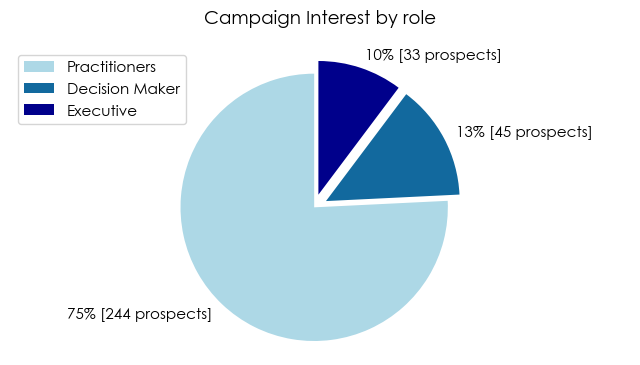

In [49]:
colors_list = ['lightblue', '#12699e', 'darkblue']
explode_list = [0.0, 0.1, 0.1]


fig, ax = plt.subplots(figsize = (8, 4), facecolor='none', edgecolor='none')
summary['% Reached'].plot(kind = 'pie',
                          autopct = None,
                          startangle = 90,
                          shadow = False,
                          labels = (summary['% Reached']).astype(int).astype(str) + '% [' + (summary['Total Reached']).astype(str) + ' prospects]',
                          pctdistance = 1.2,
                          colors = colors_list,
                          explode = explode_list,
                          ax = ax)

ax.set_ylabel('')
ax.patch.set_facecolor('none')
plt.title('Campaign Interest by role', y = 1.05)
plt.axis('equal') 
plt.legend(labels=['Practitioners', 'Decision Maker', 'Executive'], loc = 'upper left', prop = dict(size=11))
plt.savefig(r"../Output Plots/Interest_by_role.png", dpi=300, bbox_inches='tight')

plt.show()

#### The CMO is looking at performance worldwide and wants to know the performance by regions such as LATAM, EMEA, APAC and NORTHAM


---
##### I) Across the regions which campaigns performed the best in terms of **reach** (Number of prospects impacted) and **engagement** (the stage of the funnel)?

##### **Performance by region**:

# Funnel Danamics

In [50]:
campaign_summary = df1.groupby(['Role']).agg(
    awareness_count = ('Stage of the funnel', lambda x: (x >= 0.25).sum()),
    interest_count = ('Stage of the funnel', lambda x: (x >= 0.50).sum()),
    consideration_count = ('Stage of the funnel', lambda x: (x >= 0.75).sum()),
    intent_count = ('Stage of the funnel', lambda x: (x == 1).sum())
).reset_index()

campaign_summary.set_index('Role', inplace = True)
campaign_summary

,awareness_count,interest_count,consideration_count,intent_count
Role,,,,
Decision Maker,144,45,37,16
Executive,87,33,24,12
Practitioner,733,244,175,94


In [51]:
campaign_summary.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3 entries, Decision Maker to Practitioner
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   awareness_count      3 non-null      int64
 1   interest_count       3 non-null      int64
 2   consideration_count  3 non-null      int64
 3   intent_count         3 non-null      int64
dtypes: int64(4)
memory usage: 120.0+ bytes


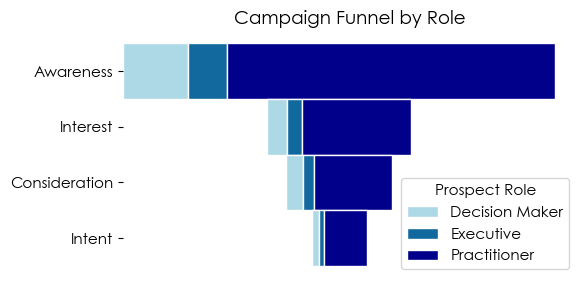

In [52]:
df = campaign_summary.copy()

# Calculate the maximum total count to center the bars around this value
max_total_count = df.sum(axis = 0).max()

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(6, 3))

# Define colors for each role
role_colors = {
    'Decision Maker': 'lightblue', 
    'Executive': '#12699e', 
    'Practitioner': 'darkblue'
}

# Sort the stages to have the funnel effect (largest to smallest)
sorted_stages = df.sum().sort_values(ascending = False).index

# Plot bars for each stage
for i, stage in enumerate(sorted_stages):
    # Get the total count for the current stage
    stage_total = df[stage].sum()
    # Calculate the left offset to center the bar
    left_offset = (max_total_count - stage_total) / 2
    
    # Plot the background bar for the total count, centered
    #ax.barh(i, stage_total, height=0.4, left=left_offset, color='grey', edgecolor='none')
    
    left = left_offset  # Set left position for stacking the roles' bars
    # Plot the stacked bars for each role within the stage
    for role in df.index:
        role_count = df.at[role, stage] 
        ax.barh(i, role_count, height = 1, left=left, color = role_colors[(role)], edgecolor='white')
        left += role_count  # Increment left position for the next role

# Invert y-axis to have the largest bar on top, creat
#  ing the funnel effect
ax.invert_yaxis()

# Set the y-ticks to be the stage names, formatted nicely
ax.set_yticks(range(len(sorted_stages)))
ax.set_yticklabels([s.replace('_count', '').capitalize() for s in sorted_stages])

# Add legend for the roles, using the color dictionary
ax.legend(role_colors.keys(), loc='lower right', title = 'Prospect Role')
ax.xaxis.set_visible(False)

plt.title('Campaign Funnel by Role')
# Remove spines and ticks for a cleaner look
spines_ = ['top', 'bottom', 'left', 'right']
[ax.spines[spine].set_visible(False) for spine in spines_]

# Show the plot
plt.tight_layout()
plt.savefig(r"../Output Plots/Funnel dynamics by role.png", dpi=300, bbox_inches='tight')
plt.show()

##### **Performance by engagement**:

In [53]:
campaign_summary = df1.groupby(['Region', 'Campaign Name']).agg(
    awareness_count = ('Stage of the funnel', lambda x: (x >= 0.25).sum()),
    interest_count = ('Stage of the funnel', lambda x: (x >= 0.50).sum()),
    consideration_count = ('Stage of the funnel', lambda x: (x >= 0.75).sum()),
    intent_count = ('Stage of the funnel', lambda x: (x == 1).sum())
).reset_index()
campaign_summary['Campaing Reachability'] = campaign_summary['awareness_count']
campaign_summary['Campaing Effectiveness'] = campaign_summary['intent_count'] / campaign_summary['Campaing Reachability'] * 100
#campaign_summary['Interest Effectiveness'] = campaign_summary['interest_count'] / campaign_summary['Campaing Reachability'] * 100

#campaign_summary['Focus Campaign indicator'] = campaign_summary['Campaing Effectiveness'] * (0.7) + campaign_summary['Interest Effectiveness'] * (0.3)

campaign_summary = campaign_summary.sort_values(by = ['Region', 'Campaing Reachability'], ascending = False,)

#campaign_summary = campaign_summary.groupby('Region').head(3).reset_index(drop = True)

campaign_summary

,Region,Campaign Name,awareness_count,interest_count,consideration_count,intent_count,Campaing Reachability,Campaing Effectiveness
251,NORTHAM,Summer Savings Extravaganza,15,3,3,3,15,20.00
196,NORTHAM,Annual Summer Clearance,12,3,0,0,12,0.00
235,NORTHAM,New Year Discounts,10,7,4,0,10,0.00
261,NORTHAM,Summer Super Sale,10,0,0,0,10,0.00
197,NORTHAM,Annual Year End Clearance,9,0,0,0,9,0.00
...,...,...,...,...,...,...,...,...
49,APAC,Summer Solstice Savings,1,0,0,0,1,0.00
50,APAC,Summer Spectacular,1,1,1,0,1,0.00
51,APAC,Summer Splash Event,1,0,0,0,1,0.00
53,APAC,Thanksgiving Sale,1,1,1,0,1,0.00


In [54]:
# Calculate engagement metrics
campaign_summary['Interest Rate'] = campaign_summary['interest_count'] / campaign_summary['awareness_count'] * 100
campaign_summary['Consideration Rate'] = campaign_summary['consideration_count'] / campaign_summary['interest_count'] * 100
campaign_summary['Intent Rate'] = campaign_summary['intent_count'] / campaign_summary['consideration_count'] * 100
campaign_summary[['Interest Rate', 'Consideration Rate', 'Intent Rate']] = campaign_summary[['Interest Rate', 'Consideration Rate', 'Intent Rate']].fillna(0)
# Sort by a combined metric of reach and engagement for a balanced view
campaign_summary['Engagement Score'] = (campaign_summary['Interest Rate'] + campaign_summary['Consideration Rate'] + campaign_summary['Intent Rate']) / 3
campaign_summary = campaign_summary.sort_values(by=['Region', 'Engagement Score', 'Campaing Reachability'], ascending = [True, False, False])

#Optionally, display the top campaigns by engagement within each region
campaign_summary = campaign_summary.groupby('Region').head(1).reset_index(drop = True)

campaign_summary[['Region', 'Campaign Name', 'Campaing Reachability', 'Engagement Score']].sort_values(by = 'Campaing Reachability', ascending = False)

,Region,Campaign Name,Campaing Reachability,Engagement Score
3,NORTHAM,Halloween Spooktacular,5,100.00
0,APAC,Annual Fall Clearance,4,100.00
1,EMEA,Spring Blowout Sale,3,100.00
2,LATAM,Annual Fall Clearance,3,100.00


---
##### II) What sources drove the most opt-in’s for the catalog?

In [55]:
opt_in_data = df1[(df1['Opt-In'] == True) & (df1['Opt-In Source'] != 'Unknown')]

opt_in_summary = opt_in_data.groupby(['Opt-In Source', 'Region']).size().unstack(fill_value = 0).reset_index()

opt_in_summary.sort_values(by = 'NORTHAM', ascending = False, inplace = True)

opt_in_summary

Region,Opt-In Source,APAC,EMEA,LATAM,NORTHAM
2,newsletter subscription,15,27,21,51
4,online purchase,25,31,18,49
6,social media campaign,21,31,19,46
5,referral program,17,35,21,45
3,online contest entry,24,34,16,40
7,website form,12,18,13,40
0,email subscription,7,23,16,33
1,event registration,16,19,12,26


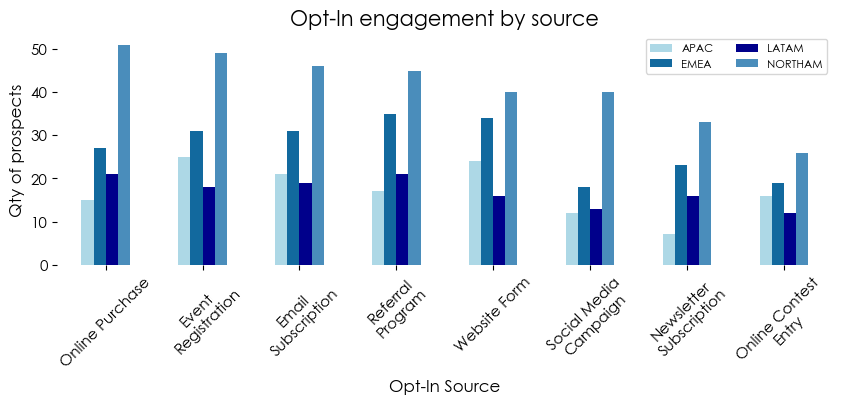

In [56]:
import textwrap

x_ticks = (opt_in_data['Opt-In Source'].str.title().unique())
colors = ['lightblue', '#12699e', 'darkblue', '#4a8dbb']
ax = opt_in_summary.plot(kind = 'bar', x = 'Opt-In Source', y = ['APAC', 'EMEA', 'LATAM', 'NORTHAM'], figsize = (10, 3), color=colors)
#ax.set_ylim(3.6, 4.4)

 #Removing axes lines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)


x_labels = x_ticks
x_wrapped = [textwrap.fill(label, 15) for label in x_labels]
plt.xticks(range(len(x_labels)), x_wrapped, rotation = 45)

plt.title("Opt-In engagement by source", fontsize = 15)
plt.xlabel('Opt-In Source', fontsize = 12)
plt.ylabel('Qty of prospects', fontsize = 12)
plt.legend(loc = 'best', fontsize = 8, ncol = 2)
ax.patch.set_facecolor('none')
plt.grid(False)
plt.savefig(r"../Output Plots/Opt_in_analysis.png", dpi = 300, bbox_inches = 'tight')

In [57]:
paretos = []
for region in ['APAC', 'EMEA', 'LATAM', 'NORTHAM']:
    temp = opt_in_summary[['Opt-In Source', f'{region}']].sort_values(by = f'{region}', ascending = False)
    temp[f'{region}_acc'] = temp[f'{region}'].cumsum() / temp[f'{region}'].sum() * 100
    temp[f'Percentage'] = temp[f'{region}'] / temp[f'{region}'].sum() * 100
    paretos.append(temp.reset_index(drop = True))
paretos[3]

Region,Opt-In Source,NORTHAM,NORTHAM_acc,Percentage
0,newsletter subscription,51,15.45,15.45
1,online purchase,49,30.30,14.85
2,social media campaign,46,44.24,13.94
3,referral program,45,57.88,13.64
4,online contest entry,40,70.00,12.12
5,website form,40,82.12,12.12
6,email subscription,33,92.12,10.00
7,event registration,26,100.00,7.88


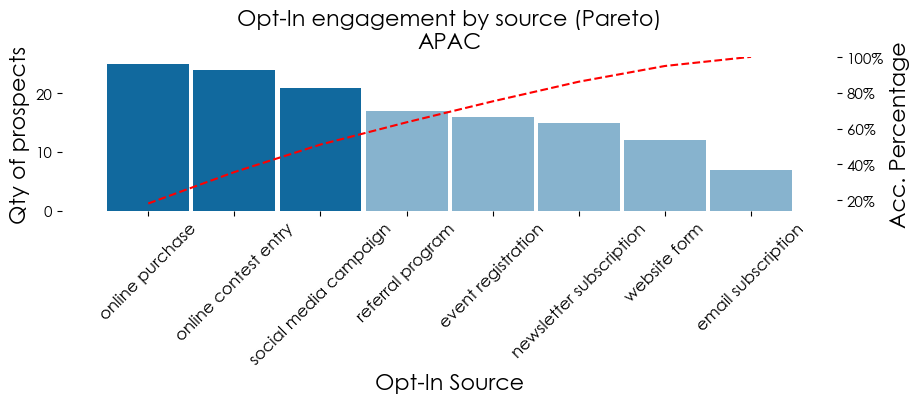

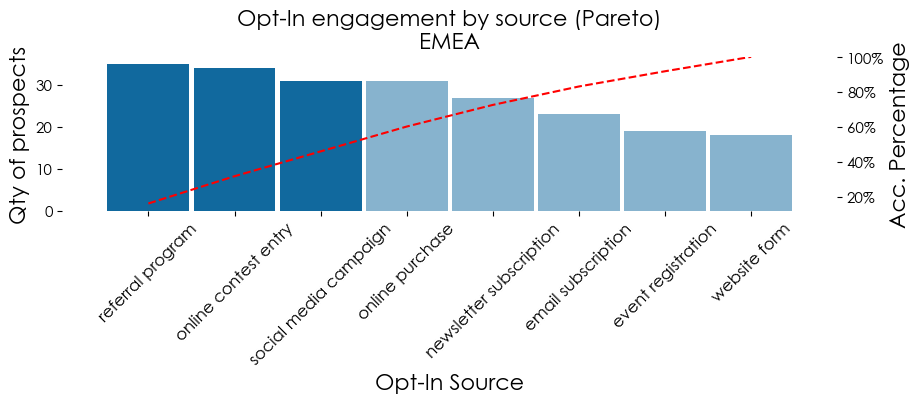

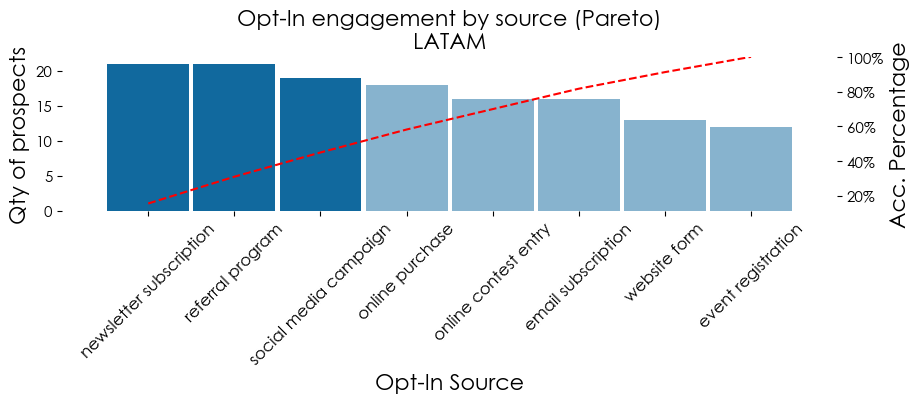

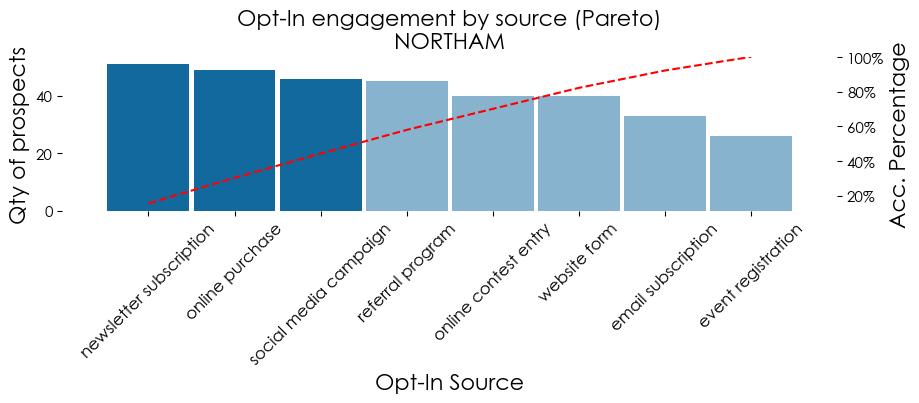

In [59]:
bar_width = 0.95
for i, region in enumerate(['APAC', 'EMEA', 'LATAM', 'NORTHAM']):
    fig, ax = plt.subplots(figsize=(10, 2), facecolor='none', edgecolor = 'none')
    ax1 = paretos[i].plot(kind = 'bar', y = f'{region}', ax = ax, color = '#11699e', width = bar_width , alpha = 0.5, legend = False)
    ax1 = paretos[i][paretos[i][f'{region}_acc'] <= 55].plot(kind = 'bar', y = f'{region}', ax = ax1, color = '#11699e', width = bar_width, legend = False)

    ax2 = ax1.twinx()
    paretos[i].plot(kind = 'line', y = f'{region}_acc', ax = ax2, style = '--r', legend = False)

    #ax.bar_label(ax1.containers[0], [f'{i * 100:.0f}%' for i in summary.explained_variance_ratio.tolist()], label_type='edge', fontsize=10)

    fz = 16
    ax.set_xticks(range(len(paretos[i].index)), paretos[i]['Opt-In Source'], rotation = 45, fontsize = fz - 4)

    ax.set_title(f'Opt-In engagement by source (Pareto)\n{region}', fontsize = fz)
    ax.set_xlabel('Opt-In Source', fontsize = fz)
    ax.set_ylabel('Qty of prospects', fontsize = fz)
    ax2.set_ylabel('Acc. Percentage', fontsize = fz)
    ax.grid(False)

    #plt.xticks(rotation = 45)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.set_ylim(top = 100)

    ax.patch.set_facecolor('none')
    plt.xlim(-1, 8)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: "{:.0f}%".format(x)))
    plt.savefig(rf'../Output Plots/Opt-In engagement by source (Pareto)_{region}.png', dpi = 300, bbox_inches = 'tight')
    plt.show()

#### Did you notice any patterns or anomalies in the data? Can you plot them?
---

- Most prospects who responded, attended, or registered opted in to receive communications.
- Even among those who were no-shows, a significant number had opted in.
- This suggests that opting in is common among all stages of the prospect journey, including those who do not ultimately attend or register. The high opt-in rates across all statuses could indicate that opting in does not necessarily predict higher engagement or conversion.


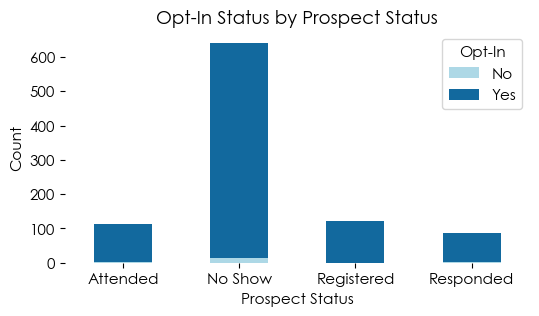

In [60]:
# Creating a new dataframe to visualize the relationship between Opt-In status and Prospect Status
opt_in_status = pd.crosstab(df1['Prospect Status'], df1['Opt-In'])

# Plotting the data
fig, ax = plt.subplots(figsize = (6, 3), facecolor='none', edgecolor = 'none')
ax1 = opt_in_status.plot(kind='bar', stacked=True, color=['lightblue', '#12699e'], ax = ax)

spines_ = ['top', 'bottom', 'left', 'right']
[ax1.spines[spine].set_visible(False) for spine in spines_]

plt.title('Opt-In Status by Prospect Status')
plt.xlabel('Prospect Status')
plt.xticks(rotation = 0)
plt.ylabel('Count')
plt.grid(False)
plt.legend(title = 'Opt-In', labels=['No', 'Yes'])
plt.savefig(rf'../Output Plots/Potential anomalies.png', dpi = 300, bbox_inches = 'tight')
plt.show()


## Normalizing Job Title

In [250]:
jts = []
for job_title in new_job_titles:
    
    instruction = f'''I need to normalize this job_titles based on their general functions. There are a lot with different titles but in general, they have the same role and responsabilities, that is what I want you to help me normalize.
                        Just give the most likely job title name in json where job_titles are the keys and job_title_normalized is the value: {job_title}'''
    
    jt = get_completion(instruction)
    jt = json.loads(jt)
    #break
    jt = pd.DataFrame.from_dict(jt, orient = 'index').reset_index()
    jt.columns = ['Job Title', 'Normalized Job Title']
    jts.append(jt)

jts = pd.concat(jts)
jts.reset_index(drop = True)
jts.drop_duplicates(subset = 'Job Title', inplace = True)
jts['Job Title'] = jts['Job Title'].str.replace('.', '')
jts

,Job Title,Normalized Job Title
0,Senior Managed Care Social Media,Social Media Specialist
1,Senior Analyst,Senior Analyst
2,Data- Bij De Gemeente Leeuwarden Analyst,Data Analyst
3,Data Analyst,Data Analyst
4,Data Scientist / Analyst / Engineer,Data Professional
...,...,...
13,Customer Insight Analyst,Market Research Analyst
14,Client Experience Analyst,Customer Experience Analyst
15,Systems Operations Analyst Ii (Americas),Systems Analyst
16,Tools & Technology Lead Senior Data Analyst,Senior Data Analyst


In [254]:
df1 = pd.merge(df1, jts, on = 'Job Title', how = 'left')
df1.to_parquet(rf'../Output Data/Normalized data.parquet', index = False)

In [66]:
df1 = pd.read_parquet(rf'../Output Data/Normalized data.parquet')
df1.head()

,Unnamed: 0,Campaign ID,Campaign Name,Prospect Status,Account ID,Account Name,Country,Prospect ID,Opt-In,Opt-In Source,Opt-In Timestamp,Opt-Out Timestamp,Job Title,Prospect Source,Role,Region,Interested,Stage of the funnel,Normalized Job Title
0,0,FY23-Q3-global-PROD461-valentines_day_special,Valentine's Day Special,No Show,0014M0000mXuCYxQAN,Coral Systems,Italy,0034M0000qUkSoNQAV,True,online purchase,2023-06-23 06:11:00,NaT,Senior Managed Care Social Media,Advertisement,Practitioner,EMEA,False,0.25,Social Media Specialist
1,1,FY23-Q3-global-PROD461-spring_flower_sale,Spring Flower Sale,No Show,0014M0000mXuCYxQAN,Coral Systems,Italy,0034M0000kCix2eQAB,True,Unknown,2023-10-05 06:11:00,NaT,Data Analyst,Advertisement,Practitioner,EMEA,False,0.25,Data Analyst
2,2,FY23-Q3-global-PROD461-summer_clearance_sale,Summer Clearance Sale,No Show,0014M0000DkP01UQAZ,Coral Systems,United States,0034M0000klMsmiQAC,True,event registration,2023-08-06 06:11:00,NaT,Senior Research Analyst,Advertisement,Practitioner,NORTHAM,False,0.25,Senior Research Analyst
3,3,FY23-Q3-global-PROD461-fall_favorites_sale,Fall Favorites Sale,No Show,0014M0000DkP01UQAZ,Coral Systems,United States,0034M0000pVRVwFQAX,True,email subscription,2023-07-01 06:11:00,NaT,"Senior Business, Payroll Systems Analyst",Trade Show,Practitioner,NORTHAM,False,0.25,Senior Business Systems Analyst
4,4,FY23-Q3-global-PROD461-spring_sales_bonanza,Spring Sales Bonanza,Responded,0014M0000DkP01UQAZ,Coral Systems,United States,0034M0000FbwBd0QAF,True,Unknown,2023-03-07 06:11:00,NaT,Information Security Analyst,Advertisement,Practitioner,NORTHAM,True,0.50,Information Security Analyst


# Statistical Techniques
---
- What influences the free trial sign ups

In [67]:
df1['Is_Registered'] = (df1['Prospect Status'] == 'Registered').astype(int)

features = ['Prospect Source', 'Role', 'Region', 'Campaign Name']

model_data = pd.get_dummies(df1[features], drop_first = True)

model_data.head()

,Prospect Source_Referral,Prospect Source_Social Media,Prospect Source_Trade Show,Role_Executive,Role_Practitioner,Region_EMEA,Region_LATAM,Region_NORTHAM,Campaign Name_Annual Fall Clearance,Campaign Name_Annual Fall Sale,...,Campaign Name_Summer Splash Sale,Campaign Name_Summer Super Sale,Campaign Name_Thanksgiving Sale,Campaign Name_Valentine's Day Special,Campaign Name_Winter Clearance,Campaign Name_Winter Discount Extravaganza,Campaign Name_Winter Savings Event,Campaign Name_Winter Wonderland,Campaign Name_Winter Wonderland Sale,Campaign Name_Year End Clearance
0,False,False,False,False,True,True,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
1,False,False,False,False,True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,True,False,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


In [68]:
from sklearn.model_selection import train_test_split

X = model_data
y = df1['Is_Registered']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [69]:
from sklearn.linear_model import LogisticRegression

# Create a logistic regression model
model = LogisticRegression()

# Train the model
model.fit(X_train, y_train)

LogisticRegression()

In [70]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate accuracy and other metrics
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")
print(f"ROC-AUC Score: {roc_auc}")

Accuracy: 0.9448275862068966
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       262
           1       0.93      0.46      0.62        28

    accuracy                           0.94       290
   macro avg       0.94      0.73      0.79       290
weighted avg       0.94      0.94      0.94       290

ROC-AUC Score: 0.9815294438386042


In [71]:
from imblearn.over_sampling import SMOTE

# Convert boolean to int if your feature set includes boolean types
X_train = X_train.astype(int)

sm = SMOTE(random_state = 42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
model.fit(X_train_res, y_train_res)

LogisticRegression()

In [72]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate accuracy and other metrics
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")
print(f"ROC-AUC Score: {roc_auc}")

Accuracy: 0.8827586206896552
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.87      0.93       262
           1       0.45      0.96      0.61        28

    accuracy                           0.88       290
   macro avg       0.72      0.92      0.77       290
weighted avg       0.94      0.88      0.90       290

ROC-AUC Score: 0.9706243184296619


In [73]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Initialize the Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC Score:", roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]))


              precision    recall  f1-score   support

           0       0.98      0.96      0.97       262
           1       0.71      0.86      0.77        28

    accuracy                           0.95       290
   macro avg       0.85      0.91      0.87       290
weighted avg       0.96      0.95      0.95       290

ROC-AUC Score: 0.9819383860414396


In [74]:
importances = rf_model.feature_importances_
feature_names = X_train.columns
feature_importance_dict = dict(zip(feature_names, importances))
sorted_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

In [75]:
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values('Importance', ascending=False)

importance_df['acc'] = importance_df.Importance.cumsum() * 100

importance_df.reset_index(inplace = True, drop = True)
importance_df[importance_df.acc <= 90]

,Feature,Importance,acc
0,Campaign Name_Annual Fall Clearance,0.08,8.10
1,Campaign Name_Spring Blowout Sale,0.06,14.41
2,Campaign Name_Winter Clearance,0.06,20.58
3,Campaign Name_End of Summer Blowout,0.06,26.41
4,Campaign Name_Fall Festival Sale,0.06,32.14
5,Campaign Name_Fall Fever Sale,0.05,37.50
6,Campaign Name_Summer Showdown,0.05,42.72
7,Campaign Name_Halloween Spooktacular,0.05,47.85
8,Campaign Name_Springtime Sale,0.05,52.45
9,Region_NORTHAM,0.04,56.92


## 
---

Key Insights from Feature Importance

- **Campaign-Specific Influence:**
The highest-ranking features are specific campaigns like 'Annual Fall Clearance', 'Spring Blowout Sale', and 'Winter Clearance'. This suggests that certain campaigns are particularly effective in driving registrations. The names suggest seasonal sales, which may indicate that timing and thematic relevance are crucial in attracting prospects.
- **Regional Influence:**
'Region_NORTHAM' also features prominently in the list, underscoring the regional influence on campaign success. This indicates that geographical targeting and regional preferences play a significant role in how well campaigns perform.
- **Prospect Source and Role:**
'Prospect Source_Trade Show' and 'Prospect Source_Referral' are relatively high on the list but not as dominant as the campaign names. This suggests that while the source of the prospect is important, it's not as decisive as the campaign specifics.
Roles like 'Role_Practitioner' and 'Role_Executive' appear further down the list, indicating they have some influence but are secondary to the campaign and region factors.

---
Certainly! Here’s a concise summary suitable for inclusion in a PowerPoint presentation:

---

### Enhancing Campaign Analysis through Detailed Features

**Current Approach:**
- Utilizing campaign names as distinct features to gauge effectiveness.
- Effective for identifying which campaigns perform well, but lacks insight into why they succeed.

**Benefits of More Granular Features:**
1. **Deeper Insights**: Identifies common strategic elements across successful campaigns.
2. **Improved Model Generalization**: Builds robustness in the model, making it applicable to new, unseen campaign data.
3. **Actionable Strategic Insights**: Allows for the design of new campaigns that integrate proven effective elements.

**Proposed Steps for Incorporation:**
- **Feature Engineering**: Develop features based on content, channel, audience, timing, and engagement metrics.
- **Cluster Analysis**: Identify and analyze groups of similar campaigns to uncover underlying patterns.
- **Hypothesis Testing**: Test specific strategies to determine their impact on trial sign-ups.

**Conclusion:**
Incorporating detailed campaign features can significantly enhance model interpretability and provide actionable insights, facilitating data-driven strategic planning and optimization of marketing efforts.

##  Is there a correlation between the prospects job title and their interest?
---
- There is no statistically significant association between the job titles of prospects and their interest level as measured by registrations:
    - **Broader Marketing Approach:** Since no specific job titles drive engagement significantly, your marketing efforts might not need to be overly customized to specific job roles. Instead, focusing on other factors like the content of the campaign, the features offered, or the overall value proposition could be more effective.

In [76]:
import scipy.stats as stats

# Crosstabulation of job titles and interest (e.g., registered for a trial)
contingency_table = pd.crosstab(df1['Normalized Job Title'], df1['Is_Registered'])

# Chi-square test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")


Chi-square statistic: 379.7740534239747
P-value: 0.5225501447809503


In [77]:
contingency_table = pd.crosstab(df1['Region'], df1['Is_Registered'])

# Chi-square test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")


Chi-square statistic: 0.5132807806638826
P-value: 0.9159641432092623


## Which marketing campaigns are the most successful?
---

In [78]:
campaign_summary = df1.groupby(['Campaign Name']).agg(
    awareness_count = ('Stage of the funnel', lambda x: (x >= 0.25).sum()),
    interest_count = ('Stage of the funnel', lambda x: (x >= 0.50).sum()),
    consideration_count = ('Stage of the funnel', lambda x: (x >= 0.75).sum()),
    intent_count = ('Stage of the funnel', lambda x: (x == 1).sum())
).reset_index()
#campaign_summary['Campaing Reachability'] = campaign_summary['awareness_count']
campaign_summary['Campaing Effectiveness'] = campaign_summary['intent_count'] / campaign_summary['awareness_count'] * 100

campaign_summary = campaign_summary.sort_values(by = ['Campaing Effectiveness'], ascending = False)

campaign_summary = campaign_summary[campaign_summary['Campaing Effectiveness'] > 0]
campaign_summary.reset_index(drop = True, inplace = True)
campaign_summary

,Campaign Name,awareness_count,interest_count,consideration_count,intent_count,Campaing Effectiveness
0,Annual Fall Clearance,13,13,13,13,100.00
1,Autumn Affair,7,7,7,7,100.00
2,Summer Showdown,6,6,6,6,100.00
3,Year End Clearance,4,4,4,4,100.00
4,Spring Blowout Sale,6,6,6,6,100.00
5,Halloween Spooktacular,6,6,6,6,100.00
6,Fall Fever Sale,5,5,5,5,100.00
7,Fall Festival Sale,6,6,6,6,100.00
8,End of Summer Blowout,7,7,7,7,100.00
9,Springtime Sale,6,6,6,6,100.00


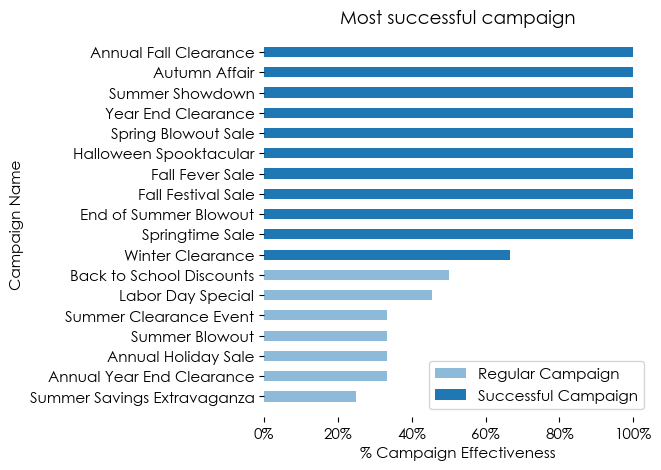

In [79]:
import textwrap

fig, ax = plt.subplots(figsize = (5, 5), facecolor='none', edgecolor = 'none')

campaign_summary.plot(x = 'Campaign Name', y = 'Campaing Effectiveness', kind = 'barh', ax = ax, alpha = 0.5)
campaign_summary[campaign_summary['Campaing Effectiveness'] >= 66].plot(x = 'Campaign Name', y = 'Campaing Effectiveness', kind = 'barh', ax = ax)

plt.ylabel('Campaign Name')
plt.xlabel('% Campaign Effectiveness')
plt.title('Most successful campaign')

spines_ = ['top', 'bottom', 'left', 'right']
[ax.spines[spine].set_visible(False) for spine in spines_]

plt.legend('')
x_labels = campaign_summary['Campaign Name'].unique()
#x_wrapped = [textwrap.fill(label, 15) for label in x_labels]
plt.yticks(range(len(x_labels)), x_labels, rotation = 0)
plt.grid(False)
plt.ylim(-1, 18)
ax.invert_yaxis()
ax.legend(['Regular Campaign', 'Successful Campaign'])
#plt.tight_layout()
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: "{:.0f}%".format(x)))
ax.patch.set_facecolor('none')
plt.savefig(rf'../Output Plots/Most successful campaign', dpi = 300, bbox_inches = 'tight')
plt.show()

##  Which prospect shows the most interest and engagement with the product?
---

In [80]:
campaign_summary = df1.groupby(['Role']).agg(
    awareness_count = ('Stage of the funnel', lambda x: (x >= 0.25).sum()),
    interest_count = ('Stage of the funnel', lambda x: (x >= 0.50).sum()),
    consideration_count = ('Stage of the funnel', lambda x: (x >= 0.75).sum()),
    intent_count = ('Stage of the funnel', lambda x: (x == 1).sum())
).reset_index()
campaign_summary['Campaing Reachability'] = campaign_summary['awareness_count']
campaign_summary['Campaing Effectiveness'] = campaign_summary['intent_count'] / campaign_summary['awareness_count'] * 100

campaign_summary = campaign_summary.sort_values(by = ['Campaing Effectiveness'], ascending = False)

campaign_summary = campaign_summary[campaign_summary['Campaing Effectiveness'] > 0]
campaign_summary.reset_index(drop = True, inplace = True)
campaign_summary

,Role,awareness_count,interest_count,consideration_count,intent_count,Campaing Reachability,Campaing Effectiveness
0,Executive,87,33,24,12,87,13.79
1,Practitioner,733,244,175,94,733,12.82
2,Decision Maker,144,45,37,16,144,11.11


##### **Performance by engagement**:

In [81]:
# Calculate engagement metrics
campaign_summary['Interest Rate'] = campaign_summary['interest_count'] / campaign_summary['awareness_count'] * 100
campaign_summary['Consideration Rate'] = campaign_summary['consideration_count'] / campaign_summary['interest_count'] * 100
campaign_summary['Intent Rate'] = campaign_summary['intent_count'] / campaign_summary['consideration_count'] * 100
campaign_summary[['Interest Rate', 'Consideration Rate', 'Intent Rate']] = campaign_summary[['Interest Rate', 'Consideration Rate', 'Intent Rate']].fillna(0)
# Sort by a combined metric of reach and engagement for a balanced view
campaign_summary['Engagement Score'] = (campaign_summary['Interest Rate'] + campaign_summary['Consideration Rate'] + campaign_summary['Intent Rate']) / 3
campaign_summary = campaign_summary.sort_values(by=['Role', 'Engagement Score', 'Campaing Reachability'], ascending=[True, False, False])

# Optionally, display the top campaigns by engagement within each region
#campaign_summary = campaign_summary.groupby('Region').head(5).reset_index(drop = True)

campaign_summary

,Role,awareness_count,interest_count,consideration_count,intent_count,Campaing Reachability,Campaing Effectiveness,Interest Rate,Consideration Rate,Intent Rate,Engagement Score
2,Decision Maker,144,45,37,16,144,11.11,31.25,82.22,43.24,52.24
0,Executive,87,33,24,12,87,13.79,37.93,72.73,50.00,53.55
1,Practitioner,733,244,175,94,733,12.82,33.29,71.72,53.71,52.91


In [82]:
campaign_summary['Engagement Score'].mean()

np.float64(52.8996919980576)

In [83]:
campaign_summary['Engagement Score'].std()

np.float64(0.6571779751198877)

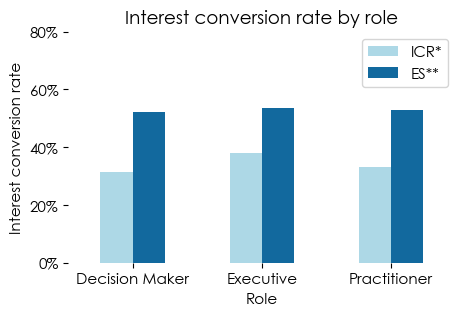

In [84]:
import textwrap
colors = ['lightblue', '#12699e']

fig, ax = plt.subplots(figsize = (5, 3), facecolor='none', edgecolor = 'none')

campaign_summary.plot(x = 'Role', y = ['Interest Rate', 'Engagement Score'], kind = 'bar', ax = ax, color = colors)

plt.xlabel('Role')
plt.ylabel('Interest conversion rate')
plt.title('Interest conversion rate by role')

spines_ = ['top', 'bottom', 'left', 'right']
[ax.spines[spine].set_visible(False) for spine in spines_]

plt.legend('')
x_labels = campaign_summary['Role'].unique()
#x_wrapped = [textwrap.fill(label, 15) for label in x_labels]
plt.xticks(range(len(x_labels)), x_labels, rotation = 0)
plt.grid(False)
plt.ylim(0, 80)
ax.legend(['ICR*', 'ES**'])
#plt.tight_layout()
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: "{:.0f}%".format(x)))
ax.patch.set_facecolor('none')
plt.savefig(rf'../Output Plots/Interest conversion rate by role', dpi = 300, bbox_inches = 'tight')
plt.show()

### Investigate the differences in the prospect characteristics and behaviors between the most successful campaign and the rest.


In [85]:
data = df1.copy()
# Counting the number of "Registered" prospects per campaign
registered_prospects_count = data[data['Prospect Status'] == 'Registered'].groupby('Campaign Name').size()

# Finding the campaign with the most registered prospects
most_successful_campaign = registered_prospects_count.idxmax()
most_successful_campaign_count = registered_prospects_count.max()

most_successful_campaign, most_successful_campaign_count


('Annual Fall Clearance', np.int64(13))

In [86]:
# Segmenting the data into the most successful campaign and others
data_most_successful = data[data['Campaign Name'] == 'Annual Fall Clearance']
data_other_campaigns = data[data['Campaign Name'] != 'Annual Fall Clearance']

# Analysis 1: Prospect Source
source_comparison = {
    'Most Successful': data_most_successful['Prospect Source'].value_counts(normalize=True),
    'Other Campaigns': data_other_campaigns['Prospect Source'].value_counts(normalize=True)
}

# Analysis 2: Job Titles and Roles
job_role_comparison = {
    'Most Successful Job Titles': data_most_successful['Job Title'].value_counts(normalize=True),
    'Other Campaigns Job Titles': data_other_campaigns['Job Title'].value_counts(normalize=True),
    'Most Successful Roles': data_most_successful['Role'].value_counts(normalize=True),
    'Other Campaigns Roles': data_other_campaigns['Role'].value_counts(normalize=True)
}

# Analysis 3: Opt-In Rates
optin_comparison = {
    'Most Successful': data_most_successful['Opt-In'].mean(),
    'Other Campaigns': data_other_campaigns['Opt-In'].mean()
}

# Analysis 4: Geographical Distribution
geography_comparison = {
    'Most Successful Country': data_most_successful['Country'].value_counts(normalize=True),
    'Other Campaigns Country': data_other_campaigns['Country'].value_counts(normalize=True),
    'Most Successful Region': data_most_successful['Region'].value_counts(normalize=True),
    'Other Campaigns Region': data_other_campaigns['Region'].value_counts(normalize=True)
}

# Analysis 5: Stage Progression in the Marketing Funnel
funnel_comparison = {
    'Most Successful': data_most_successful['Stage of the funnel'].mean(),
    'Other Campaigns': data_other_campaigns['Stage of the funnel'].mean()
}

source_comparison, job_role_comparison, optin_comparison, geography_comparison, funnel_comparison


({'Most Successful': Prospect Source
  Advertisement   0.77
  Referral        0.15
  Trade Show      0.08
  Name: proportion, dtype: float64,
  'Other Campaigns': Prospect Source
  Advertisement   0.83
  Trade Show      0.12
  Referral        0.04
  Social Media    0.01
  Name: proportion, dtype: float64},
 {'Most Successful Job Titles': Job Title
  Data Analytics Senior Director, Research                0.08
  Senior Analyst                                          0.08
  It Portfolio Delivery Director – Marketing Analytics    0.08
  Data Analyst                                            0.08
  Senior Manager, Analytics                               0.08
  Chief Data / Analytics / Ai Officer                     0.08
  Lead Analyst - Business                                 0.08
  Senior Director, Managed Markets Analytics              0.08
  Senior Investment Analyst                               0.08
  Senior Data Analyst                                     0.08
  Scheduling Support

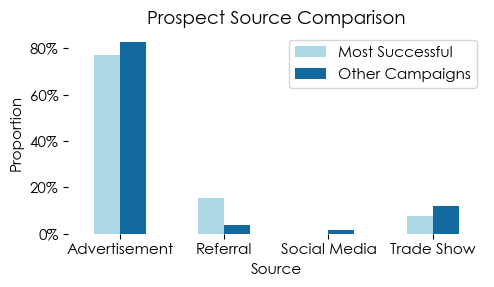

In [87]:
# 1. Prospect Source Comparison
fig, ax = plt.subplots(figsize=(5, 3))
colors = ['lightblue', '#12699e']
source_df = pd.DataFrame(source_comparison)
source_df.plot(kind='bar', ax=ax, color = colors)
[ax.spines[spine].set_visible(False) for spine in spines_]
ax.set_title('Prospect Source Comparison')
ax.set_ylabel('Proportion')
ax.set_xlabel('Source')
plt.xticks(rotation=0)
plt.tight_layout()

ax.patch.set_facecolor('none')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x*100:.0f}%"))
plt.savefig(rf'../Output Plots/Prospect Source Comparison.png', dpi = 300, bbox_inches = 'tight')
plt.show()

### Insights
---
- The bar chart above compares the prospect sources for the most successful campaign versus other campaigns. Advertisement is the dominant source for both, but the successful campaign had a higher proportion of referrals.

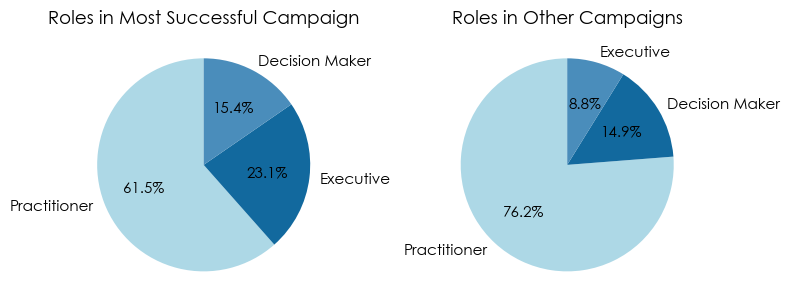

In [88]:
# 2. Job Titles and Roles Distribution
fig, axs = plt.subplots(1, 2, figsize=(8, 6))
colors = ['lightblue', '#12699e', '#4a8dbb']
# Roles for Most Successful Campaign
data_most_successful['Role'].value_counts().plot(kind='pie', ax=axs[0], autopct='%1.1f%%', startangle=90, colors = colors)
axs[0].set_ylabel('')
axs[0].set_title('Roles in Most Successful Campaign')

# Roles for Other Campaigns
data_other_campaigns['Role'].value_counts().plot(kind='pie', ax=axs[1], autopct='%1.1f%%', startangle=90, colors = colors)
axs[1].set_ylabel('')
axs[1].set_title('Roles in Other Campaigns')

plt.tight_layout()
ax.patch.set_facecolor('none')
plt.savefig(rf'../Output Plots/RolesComparison.png', dpi = 300, bbox_inches = 'tight')
plt.show()


### Insights
---
- The pie charts compare the role distributions, revealing that the most successful campaign had a higher proportion of executives and decision-makers compared to other campaigns.

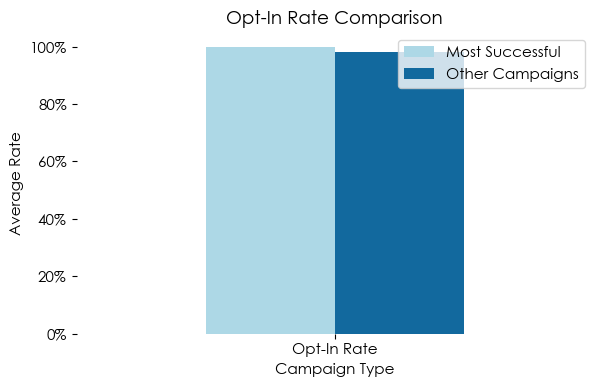

In [89]:
# 3. Opt-In Rate Comparison
fig, ax = plt.subplots(figsize=(6, 4))
colors = ['lightblue', '#12699e']
optin_df = pd.DataFrame(optin_comparison, index=['Opt-In Rate'])
optin_df.plot(kind='bar', ax=ax, color = colors)

[ax.spines[spine].set_visible(False) for spine in spines_]
ax.set_title('Opt-In Rate Comparison')
ax.set_ylabel('Average Rate')
ax.set_xlabel('Campaign Type')
plt.xticks(rotation=0)
plt.tight_layout()

# Display the figure
ax.patch.set_facecolor('none')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x*100:.0f}%"))
plt.savefig(rf'../Output Plots/Opt-In Rate Comparison.png', dpi = 300, bbox_inches = 'tight')
plt.show()


### Insights
---
- The most successful campaign achieved a perfect 100% opt-in rate, while the rate for other campaigns was slightly lower, at around 98%.

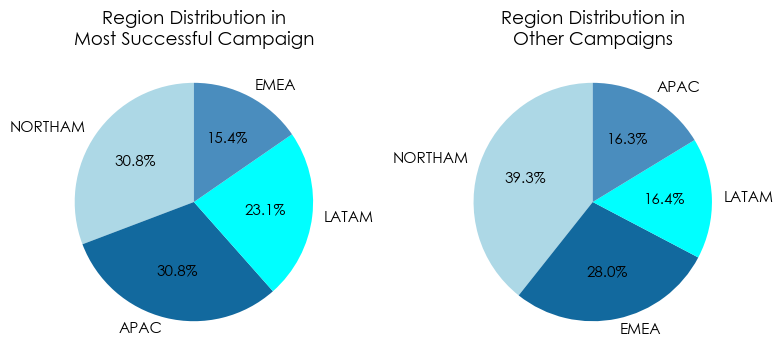

In [90]:
# 4. Geographical Distribution by Country and Region
fig, axs = plt.subplots(1, 2, figsize=(8, 6))
colors = ['lightblue', '#12699e', 'cyan', '#4a8dbe']

# Region distribution for Most Successful Campaign
data_most_successful['Region'].value_counts().plot(kind='pie', ax=axs[0], autopct='%1.1f%%', startangle=90, colors = colors)
axs[0].set_ylabel('')
axs[0].set_title('Region Distribution in\nMost Successful Campaign')

# Region distribution for Other Campaigns
data_other_campaigns['Region'].value_counts().plot(kind='pie', ax=axs[1], autopct='%1.1f%%', startangle=90, colors = colors)
axs[1].set_ylabel('')
axs[1].set_title('Region Distribution in\nOther Campaigns')

plt.tight_layout()
ax.patch.set_facecolor('none')
plt.savefig(rf'../Output Plots/Region Distribution.png', dpi = 300, bbox_inches = 'tight')
plt.show()


### Insights
---
- The left pie chart for the most successful campaign shows a nearly even distribution across NORTHAM, APAC, LATAM, and EMEA.
- The right pie chart shows that other campaigns have a stronger presence in NORTHAM, followed by EMEA.

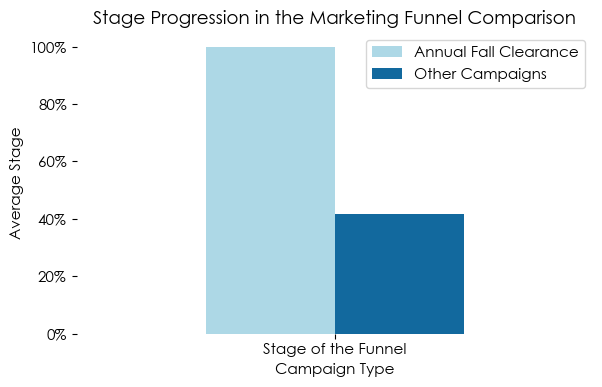

In [91]:
# 5. Stage Progression in the Marketing Funnel Comparison
fig, ax = plt.subplots(figsize=(6, 4))
colors = ['lightblue', '#12699e']
funnel_df = pd.DataFrame(funnel_comparison, index=['Stage of the Funnel'])
funnel_df.plot(kind='bar', ax=ax, color=colors)
ax.set_title('Stage Progression in the Marketing Funnel Comparison')
ax.set_ylabel('Average Stage')
ax.set_xlabel('Campaign Type')
ax.legend(['Annual Fall Clearance', 'Other Campaigns'])
[ax.spines[spine].set_visible(False) for spine in spines_]
plt.xticks(rotation=0)
plt.tight_layout()

# Display the figure
ax.patch.set_facecolor('none')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x*100:.0f}%"))
plt.savefig(rf'../Output Plots/Stage Progression in the Marketing Funnel Comparison.png', dpi = 300, bbox_inches = 'tight')
plt.show()

### Insights
---
- **Most Successful Campaign**: All prospects reached the final stage of the marketing funnel, demonstrating full progression.
- **Other Campaigns**: The average progression is significantly lower, at approximately 41.9%